In [9]:
%matplotlib inline
import math
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import numpy as np
import sys
sys.path.append("H:/WareHouse/MovieBigData/keras-movielens-cf-master/")
from CFModel import CFModel,BinaryEmbedding
from MyModel import MyModel
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.embeddings import Embedding
from sklearn import preprocessing

In [10]:
RATINGS_CSV_FILE = 'H:/WareHouse/MovieBigData/data/new_training_data.csv'
MODEL_WEIGHTS_FILE = 'my_weights.h5'
K_FACTORS = 120
RNG_SEED = 1446557
k_factors=64
def conv(val):
    if not val:
        return 0
    try:
        return np.float64(val)
    except:
        return np.float64(0)
    
def convGender(gender):
   if not gender:
       return 0
   
   if gender=="M":
       return 1
   else:
       return 0

In [11]:
ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep=',', 
                      encoding='latin-1', 
                      usecols=["user_id","movie_id","rating","id","gender","age","occupation","zip_code","genre_name","genre_vector","year","coordinates"],converters={"year": conv,"gender":convGender})
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()
max_features = 18

max_age = ratings['age'].drop_duplicates().max()



print(len(ratings), 'ratings loaded.')

500100 ratings loaded.


## Creating Training Set


In [12]:
min_max_scaler = preprocessing.MinMaxScaler()

shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)
Users = shuffled_ratings['user_id'].values
print ('Users:', Users, ', shape =', Users.shape)

Movies = shuffled_ratings['movie_id'].values
print( 'Movies:', Movies, ', shape =', Movies.shape)
Ratings = shuffled_ratings['rating'].values
print ('Ratings:', Ratings, ', shape =', Ratings.shape)
min_max_scaler.fit_transform(Ratings)

Genders= shuffled_ratings['gender'].values
print ('Genders:', Genders, ', shape =', Genders.shape)

Ages= shuffled_ratings['age'].values
print ('Ages:', Ages, ', shape =', Ages.shape)
min_max_scaler.fit_transform(Ages)

Occupations= shuffled_ratings['occupation'].values
print ('Occupations:', Occupations, ', shape =', Occupations.shape)

Genres_vectors= shuffled_ratings['genre_vector'].str.split("|",expand=True).values
print ('Genres_vectors:', Genres_vectors, ', shape =', Genres_vectors.shape)

# Genres= shuffled_ratings['genre_name'].str.split("|").va
# print ('Genres:', Genres, ', shape =', Genres.shape)


Years= shuffled_ratings['year'].values
print ('Years:', Years, ', shape =', Years.shape)


Coordinates=shuffled_ratings['coordinates'].str.split(", ",expand=True).values
# print ('Coordinates:', Coordinates, ', shape =',Coordinates .shape)

Coordinates = min_max_scaler.fit_transform(Coordinates)


print ('Coordinates:', Coordinates, ', shape =',Coordinates.shape)

Users: [3472 4077 4265 ..., 3191 3148 3650] , shape = (500100,)
Movies: [1064  506 2872 ..., 2446 1500 2485] , shape = (500100,)
Ratings: [5 3 5 ..., 3 3 3] , shape = (500100,)
Genders: [1 0 1 ..., 1 1 1] , shape = (500100,)
Ages: [25 35 25 ..., 25 18 25] , shape = (500100,)
Occupations: [ 6  2 12 ..., 12 20  0] , shape = (500100,)


H:\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
H:\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
H:\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
H:\Python\Anaconda3\lib\site-packages\sklearn\preprocessing

Genres_vectors: [['0' '0' '1' ..., '0' '0' '0']
 ['0' '0' '0' ..., '0' '0' '0']
 ['1' '0' '0' ..., '0' '0' '0']
 ..., 
 ['0' '0' '0' ..., '1' '0' '0']
 ['0' '0' '0' ..., '0' '0' '0']
 ['0' '0' '0' ..., '0' '0' '0']] , shape = (500100, 18)
Years: [ 1996.  1993.  1981. ...,  1999.  1997.  1999.] , shape = (500100,)


H:\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


Coordinates: [[ 0.49647576  0.39585952]
 [ 0.51515415  0.59915432]
 [ 1.          0.        ]
 ..., 
 [ 0.50507105  0.5546997 ]
 [ 0.41620877  0.54693829]
 [ 0.45059088  0.64632717]] , shape = (500100, 2)


In [5]:
model2=MyModel(max_userid, max_movieid,max_features,max_age,k_factors,max_occupation,max_year)
model2.compile(loss='mse', optimizer='adamax')


H:/WareHouse/MovieBigData/keras-movielens-cf-master\MyModel.py:37: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  self.add(Merge([User_S, Item_S, Genre_s, Age_s, Coor_s], mode='concat'))


In [6]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
history = model2.fit([Users, Movies,Genres_vectors,Ages,Coordinates,Occupations,Years,Genders], Ratings, nb_epoch=30, validation_split=.25, verbose=2, callbacks=callbacks)


H:\Python\Anaconda3\lib\site-packages\keras\models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 450090 samples, validate on 50010 samples
Epoch 1/5


InternalError: Blas SGEMM launch failed : a.shape=(32, 18), b.shape=(18, 3), m=32, n=3, k=18
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_dense_1_input_0/_21, dense_1/kernel/read)]]
	 [[Node: mul_1/_63 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_28_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'dense_1/MatMul', defined at:
  File "H:\Python\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "H:\Python\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "H:\Python\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "H:\Python\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "H:\Python\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "H:\Python\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "H:\Python\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "H:\Python\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "H:\Python\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "H:\Python\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "H:\Python\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "H:\Python\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "H:\Python\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "H:\Python\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "H:\Python\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "H:\Python\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "H:\Python\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "H:\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "H:\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "H:\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-abe53bac3564>", line 1, in <module>
    model2=MyModel(max_userid, max_movieid,max_features,max_age,k_factors)
  File "H:/WareHouse/MovieBigData/keras-movielens-cf-master\MyModel.py", line 23, in __init__
    Genre_s.add(Dense(embedding_size, activation="relu", use_bias=False, input_dim=max_genre_dim))
  File "H:\Python\Anaconda3\lib\site-packages\keras\models.py", line 422, in add
    layer(x)
  File "H:\Python\Anaconda3\lib\site-packages\keras\engine\topology.py", line 554, in __call__
    output = self.call(inputs, **kwargs)
  File "H:\Python\Anaconda3\lib\site-packages\keras\layers\core.py", line 842, in call
    output = K.dot(inputs, self.kernel)
  File "H:\Python\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 846, in dot
    out = tf.matmul(x, y)
  File "H:\Python\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1855, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "H:\Python\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 1454, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "H:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "H:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "H:\Python\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Blas SGEMM launch failed : a.shape=(32, 18), b.shape=(18, 3), m=32, n=3, k=18
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_dense_1_input_0/_21, dense_1/kernel/read)]]
	 [[Node: mul_1/_63 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_28_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


(0.0, 3.0)

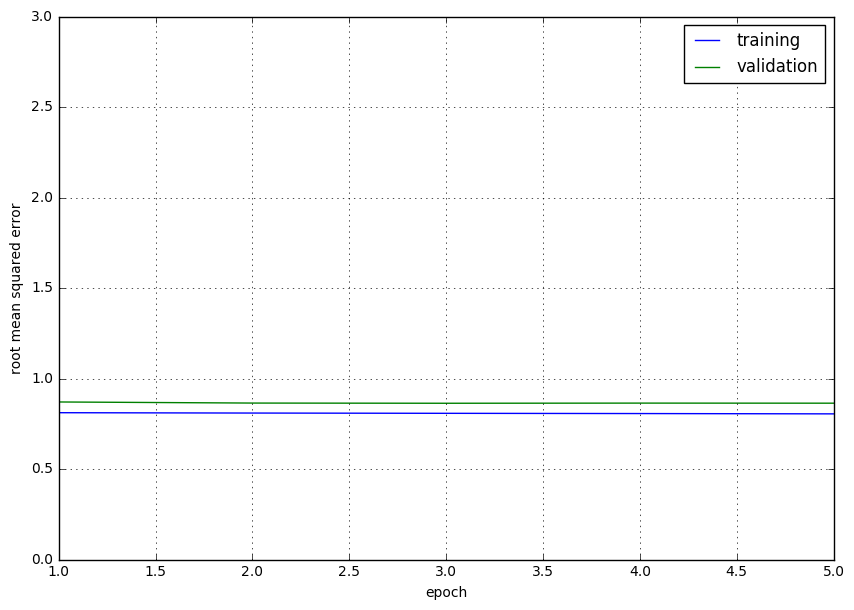

In [139]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
ax = loss.ix[:,:].plot(x='epoch', figsize={7,10}, grid=True)
ax.set_ylabel("root mean squared error")
ax.set_ylim([0.0,3.0])

In [141]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 3 = 0.8640
